# **Clustering des titres**

Le but de ce notebook est d'essayer de faire un clustering sur la colonne titres de notre fichier, a fin de pouvoir ensuite donner un thème par cluster 

In [2]:
# Importation des bibliothèques nécessaires
# pandas pour la manipulation des données 
# scikit-learn pour la création de la matrice tf-idf et le calcul de la similarité cosinus
# Dbscan pour le clustering
# nltk pour les stop words en français

import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
import numpy as np
from nltk.corpus import stopwords
import nltk
import spacy
from nltk.corpus import wordnet
from sklearn.metrics import silhouette_score

# Télécharger les stop words français si nécessaire
nltk.download('stopwords', quiet=True)
french_stop_words = stopwords.words('french')
english_stop_words = stopwords.words('english')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [3]:
# Chargement des données 
data= pd.read_csv("articles.csv")
# Nombre d'articles 
print (data.shape[0])
print (data.columns)
# Remplacer le nom de la première colonne par "id"
data.rename(columns={data.columns[0]: "id"}, inplace=True)
print (data.columns)

1269
Index(['id_article', 'title', 'year', 'language', 'Nb_authors', 'Nb_male',
       'Nb_female', 'theme', 'keywords'],
      dtype='object')
Index(['id', 'title', 'year', 'language', 'Nb_authors', 'Nb_male', 'Nb_female',
       'theme', 'keywords'],
      dtype='object')


In [4]:
# Dans le fichier y'a des articles en français et en anglais 
# Je veux spliter les articles en deux dataframes différents
data_fr = data[data['language'] == 'fr']
print (data_fr.shape[0])
data_en = data[data['language'] == 'en']
print (data_en.shape[0])

1132
122


In [5]:
# Récupération du vocabulaire français à partir des titres des articles 
# je veux le sauvgarder dans une liste 
vocab_fr = set()
for title in data_fr['title']:
    for word in title.split():
        vocab_fr.add(word.lower())

print (len(vocab_fr))

2585


In [6]:
# Récupération du vocabulaire français à partir des titres des articles en anglais
# je veux le sauvgarder dans une liste 
vocab_en = set()
for title in data_en['title']:
    for word in title.split():
        vocab_en.add(word.lower())

print (len(vocab_en))
print ((vocab_en))

547
{'bibliographical', 'science', 'video', 'on-line', 'communities', 'comparison', 'semi-interactif', 'annotated', 'apps', 'audit', 'summary', 'question', 'set', 'purchase', 'bases', 'visualization', 'total', 'level', 'bandit', 'genetic', 'ten', 'using', 'memory', 'genome-wide', 'happens', 'entropic-genetic', 'view', 'context', "d'itemsets", 'academic', 'advances', 'logic', 'hints', 'coviz', 'collaboration', 'type', 'tagger', 'visualisation,', 'scaling', 'discourse:', 'egc', 'small', 'prediction', 'spaces', 'documents', 'literary', 'cities', 'representation', 'detection:', 'co-clustering', 'inweb', 'graph', 'what', 'towards', 'corporate', 'detecting', 'visuel', 'social-attribute', 'function', 'non-disjoint', 'streams', 'leveragingweb', 'models', 'distribué', 'dissimilarity', 'keyword', 'can', 'tag', 'path', 'criteria', 'your', 'by', 'risk', 'relational', 'classifying', 'densities', 'density', 'rdf', 'closed', 'nearness', 'web', 'maintaining', 'maintenance', 'word', 'contextualization'

In [7]:
!python -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connection.py", line 203, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\util\connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\charl\AppData\Local\Programs\Python\Python312\Lib\socket.py", line 963, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
socket.gaierror: [Errno 11001] getaddrinfo failed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\charl\AppData\Local\Programs\Python\Py

In [8]:
# Lemmatisation

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def lemmatiser_anglais(texte):
    doc = nlp(str(texte).lower())
    # On garde le lemme si ce n'est pas une ponctuation ou un stop word
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

data_en['title_lemmatize'] = data_en['title'].apply(lemmatiser_anglais)

C:\Users\charl\AppData\Local\Temp\ipykernel_18668\174525150.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['title_lemmatize'] = data_en['title'].apply(lemmatiser_anglais)


In [9]:
# Affichage après lemmatisation
vocab_en = set()
for title in data_en['title_lemmatize']:
    for word in title.split():
        vocab_en.add(word.lower())

print (len(vocab_en))
print ((vocab_en))

457
{'bibliographical', 'science', 'video', 'comparison', 'summary', 'audit', 'distribution', '0', 'question', 'handle', 'set', 'purchase', 'visualization', 'total', 'level', 'bandit', 'genetic', 'interval', 'socio', 'memory', 'view', 'context', 'academic', 'logic', 'learn', 'coviz', 'collaboration', 'basis', 'type', 'tagger', 'drive', 'database', 'egc', 'small', 'prediction', 'co', 'literary', 'representation', 'inweb', 'graph', 'corporate', 'visuel', 'function', 'spot', 'leveragingweb', 'sample', 'distribué', 'understand', 'aware', 'dissimilarity', 'keyword', 'maintain', 'tag', 'path', 'risk', 'assess', 'non', 'relational', 'density', 'rdf', 'nearness', 'web', 'value', 'word', 'contextualization', 'maintenance', 'entropic', 'clustering', 'broad', 'reason', 'factor', 'avec', 'detect', 'partition', 'browse', 'technique', 'fisher', 'hypergraph', 'automatic', 'open', 'moi', 'prospect', 'long', 'fringe', 'expression', 'formalism', 'heuristic', 'early', 'biological', 'derive', 'influence',

In [10]:
# Désambiguïsation (regroupement de synonymes)

def reduire_synonymes(mot):
    # On cherche les synonymes du mot
    if len(str(mot)) <= 3:
        return mot
    synsets = wordnet.synsets(mot)
    if synsets:
        # On récupère le nom du premier concept (le plus commun)
        # ex: 'big' et 'large' pourraient tous deux renvoyer 'large'
        return synsets[0].lemmas()[0].name()
    return mot

def traiter_synonymes(texte_lemmatize):
    mots = str(texte_lemmatize).split()
    # Remplace chaque mot par son synonyme pivot
    mots_unifies = [reduire_synonymes(m) for m in mots]
    return " ".join(mots_unifies)

data_en['title_clear'] = data_en['title_lemmatize'].apply(traiter_synonymes)


C:\Users\charl\AppData\Local\Temp\ipykernel_18668\1867460168.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['title_clear'] = data_en['title_lemmatize'].apply(traiter_synonymes)


In [11]:
# Affichage après désambiguïsation (regroupement de synonymes)
vocab_en = set()
for title in data_en['title_clear']:
    for word in title.split():
        vocab_en.add(word.lower())

print (len(vocab_en))
print ((vocab_en))

441
{'aggregate', 'science', 'video', 'on-line', 'comparison', 'intercede', 'summary', 'consecutive', 'distribution', '0', 'question', 'handle', 'set', 'purchase', 'bandit', 'socio', 'memory', 'context', 'logic', 'learn', 'coviz', 'collaboration', 'type', 'tagger', 'scheme', 'drive', 'database', 'visual_image', 'honkytonk', 'egc', 'small', 'prediction', 'co', 'literary', 'representation', 'deduction', 'inweb', 'moral_force', 'graph', 'corporate', 'familial', 'visuel', 'function', 'cleavage', 'topographic_point', 'regulate', 'leveragingweb', 'sample', 'distribué', 'sphere', 'understand', 'aware', 'real_number', 'dissimilarity', 'keyword', 'tag', 'keep', 'non', 'relational', 'density', 'rdf', 'nearness', 'web', 'value', 'word', 'contextualization', 'entropic', 'broad', 'time_interval', 'collection', 'reason', 'factor', 'avec', 'detect', 'partition', 'browse', 'technique', 'hypergraph', 'open', 'moi', 'prospect', 'expression', 'position', 'formalism', 'heuristic', 'early', 'biological', '

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.8, min_df=2) 
X = vectorizer.fit_transform(data_en['title_clear'])

print(f"Forme de la matrice : {X.shape}")

Forme de la matrice : (122, 133)


In [ ]:
dbscan = DBSCAN(eps=0.6, min_samples=3, metric='cosine')

clusters = dbscan.fit_predict(X)

data_en['cluster'] = clusters

C:\Users\charl\AppData\Local\Temp\ipykernel_18668\1572831223.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_en['cluster'] = clusters


In [ ]:
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f"Nombre de clusters trouvés : {n_clusters}")

for i in range(n_clusters):
    print(f"\n--- CLUSTER {i} ---")
    print(data_en[data_en['cluster'] == i]['title'].head(10).values)

Nombre de clusters trouvés : 7

--- CLUSTER 0 ---
['Big Data for understanding human dynamics: the power of networks'
 'Mean-shift : Clustering scalable et distribué'
 'Temporal hints in the cultural heritage discourse: what can an ontology of time as it is worded reveal?'
 'Machine Learning Based Classification of Android Apps through Text Features'
 'Machine Learning for the Semantic Web: filling the gaps in Ontology Mining'
 'Analyse exploratoire par k-Coclustering avec Khiops CoViz'
 'Clustering visuel semi-interactif' 'Fairness-Aware Data Mining'
 'Towards generic and efficient constraint-based mining, a constraint programming approach'
 'A Framework for Mesh Segmentation and Annotation using Ontologies']

--- CLUSTER 1 ---
['Community structure in complex networks'
 'Long-range influences in (social) networks'
 'Incremental learning with latent factor models for attribute prediction in social-attribute networks'
 'Community Detection in Social Networks with Attribute and Relation

In [30]:
# 1. Compter le nombre de titres par cluster
counts = data_en['cluster'].value_counts().sort_index()

# 2. Affichage propre
print("Nombre de documents par cluster :")
print("-" * 30)
for cluster_id, count in counts.items():
    if cluster_id == -1:
        print(f"Bruit (Noise -1) : {count} documents")
    else:
        print(f"Cluster {cluster_id}      : {count} documents")

Nombre de documents par cluster :
------------------------------
Bruit (Noise -1) : 41 documents
Cluster 0      : 58 documents
Cluster 1      : 6 documents
Cluster 2      : 3 documents
Cluster 3      : 3 documents
Cluster 4      : 4 documents
Cluster 5      : 4 documents
Cluster 6      : 3 documents


In [23]:
# Construction de la matrice TF-IDF pour les articles en français en utilisant seulement les titres
# On doit utiliser les stop word de la langue française
vectorizer_fr = TfidfVectorizer(stop_words=french_stop_words)
tfidf_matrix_fr = vectorizer_fr.fit_transform(data_fr['title'])
# Affichage de nombre de termes dans le vocabulaire
print("Nombre de termes dans le dictionnaire (français) :", len(vectorizer_fr.get_feature_names_out()))

Nombre de termes dans le dictionnaire (français) : 2339


In [10]:
# Construction de la matrice TF-IDF pour les articles en anglais
vectorizer_en = TfidfVectorizer(stop_words='english')
tfidf_matrix_en = vectorizer_en.fit_transform(data_en['title'])
# Affichage de nombre de termes dans le vocabulaire
print("Nombre de termes dans le dictionnaire (anglais) :", len(vectorizer_en.get_feature_names_out()))

Nombre de termes dans le dictionnaire (anglais) : 487


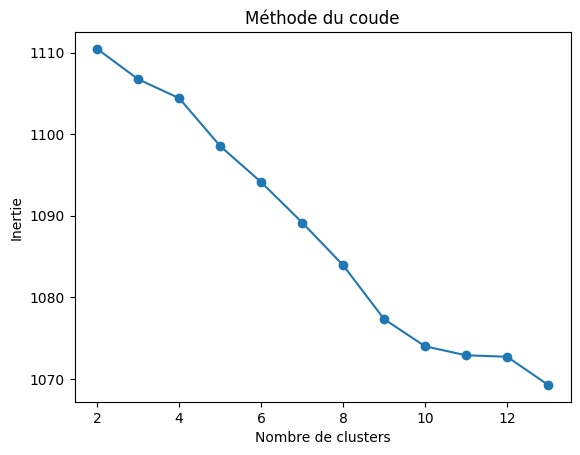

In [25]:
# Construction des clusters 
# Commençons avec les articles en français
# On utilise en premier le k-means 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 14)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix_fr)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude")
plt.show()

In [38]:
# Application du K-means 
k = 11
kmeans = KMeans(n_clusters=k, random_state=42)
data_fr["cluster"] = kmeans.fit_predict(tfidf_matrix_fr)

C:\Users\HP\AppData\Local\Temp\ipykernel_6512\3022106356.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr["cluster"] = kmeans.fit_predict(tfidf_matrix_fr)


In [39]:
terms = vectorizer_fr.get_feature_names_out()

In [40]:
import numpy as np

def get_top_words_per_cluster(model, terms, n_words=10):
    for i, centroid in enumerate(model.cluster_centers_):
        top_indices = centroid.argsort()[-n_words:][::-1]
        top_terms = [terms[ind] for ind in top_indices]
        print(f"Cluster {i} : {', '.join(top_terms)}")
get_top_words_per_cluster(kmeans, terms)

Cluster 0 : approche, sémantique, graphes, ontologie, connaissances, réseaux, détection, méthode, sociaux, basée
Cluster 1 : découverte, intégration, motifs, données, connaissances, contraintes, bases, sous, sgbd, chroniques
Cluster 2 : système, aide, connaissances, extraction, information, décision, hybride, données, apprentissage, multi
Cluster 3 : règles, association, recherche, information, approche, extraction, images, génération, nouvelle, floues
Cluster 4 : analyse, données, application, symboliques, concepts, web, site, sociaux, connaissances, exploratoire
Cluster 5 : vers, échelle, traitement, grande, données, images, sémantique, approche, multi, gestion
Cluster 6 : extraction, motifs, séquentiels, partir, connaissances, données, web, fréquents, relations, séquences
Cluster 7 : sélection, systèmes, variables, supervisé, apprentissage, pair, approche, données, rapide, construction
Cluster 8 : apprentissage, supervisée, non, classification, supervisé, données, partir, méthode, s

In [37]:
for i in range(k):
    print(f"\n### Cluster {i}")
    print(data_fr[data_fr["cluster"] == i]["title"].head(10).values)


### Cluster 0
["#Idéo2017 : une plateforme citoyenne dédiée à l'analyse des tweets lors des événements politiques"
 'ALGeoSPF: Un modèle de factorisation basé sur du clustering géographique pour la recommandation de POI'
 "Analyse des sentiments à partir des commentaires Facebook publiés en Arabe standard ou dialectal marocain par une approche d'apprentissage automatique"
 'Analyse en rôles sémantiques pour le résumé automatique'
 'Analyse Ontologique de scénario dans un contexte Big Data'
 'Apport des modèles locaux pour les K-moyennes prédictives'
 'Apprendre les relations de préférence et de co-occurrence entre les labels en classification multi-labels'
 'Approche contextuelle par régression pour les tests A/B'
 'Cartes Auto-Organisatrices Incrémentales appliquées au Clustering Collaboratif'
 "Catégorisation d'articles scientifiques basée sur les relations sémantiques des mots-clés"]

### Cluster 1
["Découverte de motifs graduels partiellement ordonnés : application aux données d'e

In [35]:
len(data_fr)

1133